In [1]:
import h5py
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.layers import (Dense, Reshape, Conv2D, LeakyReLU, BatchNormalization,
                          LocallyConnected2D, Activation, ZeroPadding2D,
                          Dropout, Lambda, Flatten, Input, add)

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, classification_report

from functools import partial
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as func 
from torch.nn.functional import normalize
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

2022-12-07 06:44:57.374452: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [88]:
# Choose Calo Particles
CLASS_ONE = 'gamma'
CLASS_TWO = 'eplus'
c1 = h5py.File('/fast_scratch_1/QVAE/data/calo_scaled/'+CLASS_ONE+'.hdf5', 'r')
c2 = h5py.File('/fast_scratch_1/QVAE/data/calo_scaled/'+CLASS_TWO+'.hdf5', 'r')

In [89]:
c1_layer_0 = torch.tensor(np.array(c1['layer_0']))
c1_layer_1 = torch.tensor(np.array(c1['layer_1']))
c1_layer_2 = torch.tensor(np.array(c1['layer_2']))
c1_flatten_0 = torch.flatten(c1_layer_0, start_dim=1)
c1_flatten_1 = torch.flatten(c1_layer_1, start_dim=1)
c1_flatten_2 = torch.flatten(c1_layer_2, start_dim=1)
c1 = torch.cat((c1_flatten_0,c1_flatten_1,c1_flatten_2), dim=1)

In [90]:
c2_layer_0 = torch.tensor(np.array(c2['layer_0']))
c2_layer_1 = torch.tensor(np.array(c2['layer_1']))
c2_layer_2 = torch.tensor(np.array(c2['layer_2']))
c2_flatten_0 = torch.flatten(c2_layer_0, start_dim=1)
c2_flatten_1 = torch.flatten(c2_layer_1, start_dim=1)
c2_flatten_2 = torch.flatten(c2_layer_2, start_dim=1)
c2 = torch.cat((c2_flatten_0,c2_flatten_1,c2_flatten_2), dim=1)

In [91]:
# c1 = c1_flatten_1 # take only layer 2
# c2 = c2_flatten_1 # tke only layer 2

In [92]:
print('Number of {} events = {}'.format(CLASS_ONE, c1[0].shape[0]))
print('Number of {} events = {}'.format(CLASS_TWO, c2[0].shape[0]))


Number of gamma events = 504
Number of eplus events = 504


In [93]:
# define labels
c1_labels = torch.ones(c1.size(0)) # ones
c2_labels = torch.zeros(c2.size(0)) # zeros
inputs = torch.cat((c1, c2), dim=0) # flattening dimension 1
#inputs = normalize(inputs, dim=1)
labels = torch.cat((c1_labels, c2_labels), dim=0)
dataset = TensorDataset(inputs, labels)
# data_loader = DataLoader(dataset, shuffle=True, batch_size=inputs.size(0))
# inputs = next(iter(data_loader))[0].float()/1000.
# targets = next(iter(data_loader))[1]


In [94]:
inputs.size()

torch.Size([200000, 504])

In [95]:
rand_perm = torch.randperm(inputs.size(0))
inputs = inputs[rand_perm].float()/1000
targets = labels[rand_perm]

In [96]:
targets

tensor([0., 1., 0.,  ..., 1., 0., 1.])

In [97]:
class Net(nn.Module):
    """
    This class builds the neural network structure with 3 layers.
        Layer 1: num_features number of units
        layer 2: num_hiddden_units=100 hidden units seem to work well
        layer 3: num_classes=5 number of output classes
    """
    def __init__(self, num_features,  num_classes):
        super(Net, self).__init__() 
        self.fc1= nn.Linear(num_features, 512)
        self.nfc1 = nn.BatchNorm1d(512)
        
        self.fc2= nn.Linear(512, 1024)
        self.nfc2 = nn.BatchNorm1d(1024)
        
        self.fc3= nn.Linear(1024, 2048)
        self.nfc3 = nn.BatchNorm1d(2048)
        
        self.fc4= nn.Linear(2048, 1024)
        self.nfc4 = nn.BatchNorm1d(1024)
        
        self.fc5= nn.Linear(1024, 128)
        self.nfc5 = nn.BatchNorm1d(128)
        
        self.fc6= nn.Linear(128, num_classes)
    
    def forward(self, x):
        h1 = self.nfc1(func.dropout(func.leaky_relu(self.fc1(x)),p=0.02))
        h2 = self.nfc2(func.dropout(func.leaky_relu(self.fc2(h1)),p=0.05))
        h3 = self.nfc3(func.dropout(func.leaky_relu(self.fc3(h2)),p=0.05))
        h4 = self.nfc4(func.dropout(func.leaky_relu(self.fc4(h3)),p=0.05))
        h5 = func.dropout(func.leaky_relu(self.fc5(h4)),p=0.005)
        y = torch.sigmoid(self.fc6(h5))
        
#         h1 = torch.relu(self.fc1(x))
#         h1 = func.dropout(h1,p=0.25)
#         y = torch.sigmoid(self.fc2(h1))
        return y

    def reset(self):
        self.fc1.reset_parameters()
        self.fc2.reset_parameters()

In [82]:
model = Net(num_features=504, num_classes=1)
num_epochs=100
display_epochs=2
optimizer = optim.Adam(model.parameters(), lr=0.20)
loss = torch.nn.BCELoss(reduction= 'mean')
obj_vals= []  
for epoch in range(num_epochs):   
    model_output = model.forward(inputs).reshape(-1)
    pred = (model_output>0.5).float()
    diff_tensor =  pred - targets 
    diff_tensor = torch.abs(diff_tensor)
    accuracy = 1-torch.sum(diff_tensor)/pred.size(0)
    obj_val = loss(model_output, targets)
    optimizer.zero_grad() 
    obj_val.backward() 
    optimizer.step() 
    obj_vals.append(obj_val.item())
    if (epoch+1) % display_epochs == 0:
        print ('Epoch [{}/{}]\tTrain Loss :{:.4f}\t accuracy :{:.4f}%'.format(epoch+1, num_epochs, obj_val.item(), accuracy*100))
print("\nTraining Completed")

Epoch [2/100]	Train Loss :50.0000	 accuracy :50.0000%
Epoch [4/100]	Train Loss :50.0000	 accuracy :50.0000%
Epoch [6/100]	Train Loss :50.0000	 accuracy :50.0000%


KeyboardInterrupt: 

--- Logging error ---
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
    await self.process_one()
  File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 450, in process_one
    await dispatch(*args)
TypeError: object NoneType can't be used in 'await' expression

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/logging/__init__.py", line 1089, in emit
    self.flush()
  File "/opt/conda/lib/python3.8/logging/__init__.py", line 1069, in flush
    self.stream.flush()
OSError: [Errno 5] Input/output error
Call stack:
  File "/opt/conda/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.8/site-packages/ipykernel_launch

In [37]:
concat = partial(np.concatenate, axis=0)
def load_calodata(fpaths):
    '''
    Returns:
    --------
        data: a list of 3 numpy arrays, representing the energy deposition in each layer
            for a group of showers contained in the file 'fpath'
    '''
    for fpath in fpaths:
        with h5py.File(fpath, 'r') as h5:
            try:
                data = [concat((data[i], h5['layer_{}'.format(i)][:])) for i in xrange(3)]
            except NameError:
                data = [h5['layer_{}'.format(i)][:] for i in range(3)]
    return data
import glob
print('Extraing data for ' + CLASS_ONE)
# c1 = load_calodata(glob.glob(('../data/classification/{}_extra.hdf5').format(CLASS_ONE)))
c1 = load_calodata(glob.glob(('/fast_scratch_1/QVAE/data/calo_scaled/{}.hdf5').format(CLASS_ONE)))
print('Extraing data for ' + CLASS_TWO) 
    
 # c2 = load_calodata(glob.glob(('../data/classification/{}_extra.hdf5').format(CLASS_TWO)))
c2 = load_calodata(glob.glob(('/fast_scratch_1/QVAE/data/calo_scaled/{}.hdf5').format(CLASS_TWO)))
data = map(concat, zip(c1, c2))
c_copy = c2
for i in range(3):
    print("list element is {0}".format(len(c_copy[i])))
    c_copy = c_copy[i]

labels = np.array([1] * c1[0].shape[0] + [0] * c2[0].shape[0])
print('Number of {} events = {}'.format(CLASS_ONE, c1[0].shape[0]))
print('Number of {} events = {}'.format(CLASS_TWO, c2[0].shape[0]))

Extraing data for gamma
Extraing data for eplus
list element is 100000
list element is 3
list element is 96
Number of gamma events = 100000
Number of eplus events = 100000


In [31]:
def build_simple_dnn(x):

    h = Dense(512)(x)
    h = Dropout(0.2)(LeakyReLU()(h))
    h = BatchNormalization()(h)

    h = Dense(1024)(h)
    h = Dropout(0.5)(LeakyReLU()(h))
    h = BatchNormalization()(h)

    h = Dense(2048)(h)
    h = Dropout(0.5)(LeakyReLU()(h))
    h = BatchNormalization()(h)
    
    h = Dense(1024)(h)
    h = Dropout(0.5)(LeakyReLU()(h))
    h = BatchNormalization()(h)

    h = Dense(128)(h)
    h = Dropout(0.5)(LeakyReLU()(h))

    h = Dense(1)(h)
    y = Activation('sigmoid')(h)
    

    return y

In [33]:
# c_copy = data_train
# for i in range(10):
#     print("list element is {0}".format(len(c_copy[i])))
#     c_copy = c_copy[i]

# print(len(raveled_train[12212]))

In [38]:
np.random.seed(0)
ix = np.array(range(len(labels)))
np.random.shuffle(ix)
print("lenght of labels is {0}".format(len(labels)))
# number of examples to train on
nb_train = int(0.7 * len(ix))
print("check: len(ix): {0} should be same as label length".format(len(ix)))
print("nb_train is {0}".format(nb_train))
# train test split
ix_train = ix[:nb_train]
ix_test = ix[nb_train:]
temp_data = data
# print("temp data has length {0}".format(len(data)))
data_train = [np.expand_dims(d[ix_train], -1) / 1000. for d in data]
labels_train = labels[ix_train]

data_test = [np.expand_dims(d[ix_test], -1) / 1000. for d in data]
labels_test = labels[ix_test]
raveled_train = np.concatenate([d.reshape(d.shape[0], -1) for d in data_train], axis=-1)
#raveled_test = np.concatenate([d.reshape(d.shape[0], -1) for d in data_test], axis=-1)


lenght of labels is 200000
check: len(ix): 200000 should be same as label length
nb_train is 140000


In [41]:
raveled_train[100001]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 5.61773439e-04, 0.00000000e+00, 0.00000000e+00,
       2.80619865e-04, 0.00000000e+00, 5.79188634e-04, 9.07821531e-04,
       1.71390785e-04, 8.30030924e-04, 0.00000000e+00, 9.93952746e-04,
       0.00000000e+00, 3.51070043e-04, 3.14667188e-03, 5.48833434e-04,
       2.52487668e-04, 2.52544127e-03, 5.74802368e-04, 7.04072118e-04,
       4.39949484e-04, 1.63612926e-03, 1.84211574e-03, 2.57255855e-04,
       3.83355065e-04, 4.17382132e-03, 8.58926646e-04, 4.24796669e-04,
       0.00000000e+00, 1.38631584e-03, 7.00177967e-04, 1.54930432e-03,
       6.36034423e-04, 1.04223261e-03, 3.50925203e-04, 0.00000000e+00,
       0.00000000e+00, 2.72405986e-04, 1.55306377e-05, 0.00000000e+00,
       0.00000000e+00, 2.59150967e-04, 7.29482081e-04, 7.73837362e-04,
      

In [42]:
inputs[100001]/1000.

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 5.6177e-04, 0.0000e+00, 0.0000e+00, 2.8062e-04, 0.0000e+00,
        5.7919e-04, 9.0782e-04, 1.7139e-04, 8.3003e-04, 0.0000e+00, 9.9395e-04,
        0.0000e+00, 3.5107e-04, 3.1467e-03, 5.4883e-04, 2.5249e-04, 2.5254e-03,
        5.7480e-04, 7.0407e-04, 4.3995e-04, 1.6361e-03, 1.8421e-03, 2.5726e-04,
        3.8336e-04, 4.1738e-03, 8.5893e-04, 4.2480e-04, 0.0000e+00, 1.3863e-03,
        7.0018e-04, 1.5493e-03, 6.3603e-04, 1.0422e-03, 3.5093e-04, 0.0000e+00,
        0.0000e+00, 2.7241e-04, 1.5531e-05, 0.0000e+00, 0.0000e+00, 2.5915e-04,
        7.2948e-04, 7.7384e-04, 1.8108e-03, 0.0000e+00, 2.7653e-03, 2.1721e-03,
        2.5896e-04, 1.4040e-03, 1.3287e-03, 1.5225e-04, 1.2133e-03, 0.0000e+00,
        0.0000e+00, 1.2706e-05, 1.0546e-03, 0.0000e+00, 8.2384e-05, 0.0000e+00,
        0.0000e+00, 9.2922e-04, 8.8626e-

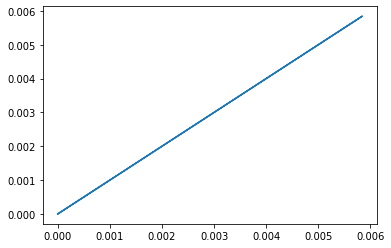

In [62]:
num = 11
plt.plot(inputs[num].detach().numpy(), raveled_train[num])

In [72]:
labels_train[100001-2]

1

In [73]:
targets[100001-2]

tensor(1.)

In [15]:
i = 0
for d in data_train:
    print("d.shape is {0}".format(d.shape[1]))
    i = i + 1
    if i==20:
        break


d.shape is 3
d.shape is 12
d.shape is 12


In [6]:
print(ix)

[ 54458 118646  57401 ... 173685  43567 199340]


In [15]:
print("data_train has length {0}".format(len(data_train[0][0][0])))

data_train has length 96


In [19]:
c_copy = data_train
for i in range(4):
    print("list element is {0}".format(len(c_copy[i])))
    c_copy = c_copy[i]

list element is 140000
list element is 3
list element is 96
list element is 1


In [39]:
inputs = torch.from_numpy(raveled_train).to(torch.float32)
targets = torch.from_numpy(labels_train).to(torch.float32)

In [40]:
model_output = model.forward(inputs).reshape(-1)
model_output.size()

torch.Size([140000])

In [98]:
model = Net(num_features=504, num_classes=1)
num_epochs=75
display_epochs=2
optimizer = optim.Adam(model.parameters(), lr=0.075)
loss = torch.nn.BCELoss(reduction= 'mean')
obj_vals= []  
accuracies = []
for epoch in range(num_epochs):   
    model_output = model.forward(inputs).reshape(-1)
    pred = (model_output>0.5).float()
    #print("model_out is {0}\n and pred is {1}\n and target is {2}\n\n".format(model_output, pred, targets))
    diff_tensor =  pred - targets 
    diff_tensor = torch.abs(diff_tensor)
    accuracy = 1-torch.sum(diff_tensor)/pred.size(0)
    accuracies.append(accuracy)
    obj_val = loss(model_output, targets)
    optimizer.zero_grad() 
    obj_val.backward() 
    optimizer.step() 
    obj_vals.append(obj_val.item())
    if (epoch+1) % display_epochs == 0:
        print ('Epoch [{}/{}]\tTrain Loss :{:.4f}\t accuracy :{:.4f}%'.format(epoch+1, num_epochs, obj_val.item(), accuracy*100))
print("\nTraining Completed")

Epoch [2/75]	Train Loss :31.2116	 accuracy :50.0000%
Epoch [4/75]	Train Loss :25.0727	 accuracy :55.4075%
Epoch [6/75]	Train Loss :13.0005	 accuracy :59.3695%
Epoch [8/75]	Train Loss :6.4115	 accuracy :59.4630%
Epoch [10/75]	Train Loss :3.2084	 accuracy :57.2675%
Epoch [12/75]	Train Loss :3.6782	 accuracy :54.5845%
Epoch [14/75]	Train Loss :3.2399	 accuracy :52.2855%
Epoch [16/75]	Train Loss :5.6234	 accuracy :59.0955%
Epoch [18/75]	Train Loss :2.1522	 accuracy :63.3360%
Epoch [20/75]	Train Loss :0.9740	 accuracy :62.2620%
Epoch [22/75]	Train Loss :1.0306	 accuracy :52.7370%
Epoch [24/75]	Train Loss :1.1042	 accuracy :56.9375%
Epoch [26/75]	Train Loss :0.8915	 accuracy :54.5170%
Epoch [28/75]	Train Loss :0.7955	 accuracy :55.5310%
Epoch [30/75]	Train Loss :0.8233	 accuracy :51.3665%
Epoch [32/75]	Train Loss :0.7359	 accuracy :61.9930%
Epoch [34/75]	Train Loss :0.7162	 accuracy :63.4495%
Epoch [36/75]	Train Loss :0.6846	 accuracy :62.6970%
Epoch [38/75]	Train Loss :0.6725	 accuracy :62.

In [119]:
torch.set_printoptions(profile="default")
print(targets)


tensor([1., 0., 1.,  ..., 1., 0., 1.])


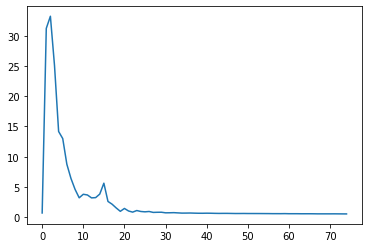

In [99]:
plt.plot(range(num_epochs), obj_vals)

Text(0, 0.5, 'Training Accuracies')

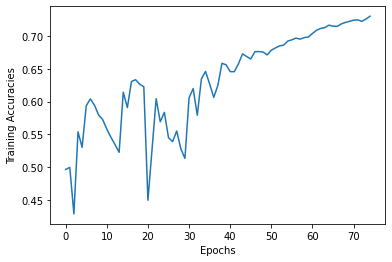

In [100]:
plt.plot(range(num_epochs), accuracies, '-')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracies')

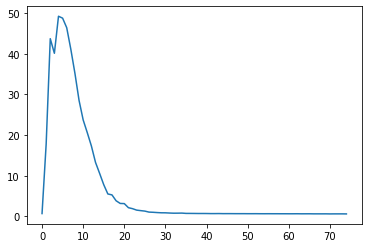

In [86]:
plt.plot(range(num_epochs), obj_vals)

Text(0, 0.5, 'Training Accuracies')

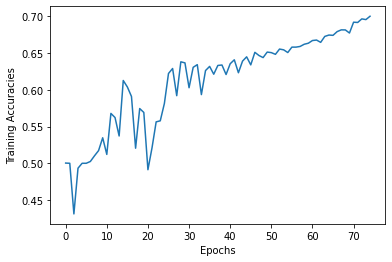

In [87]:
plt.plot(range(num_epochs), accuracies, '-')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracies')

In [ ]:
"""
Remainder of notebook has stuff from the caloClassifierV1 which is apparently useless ...
"""
# class Net(nn.Module):
#     def __init__(self, num_features,  num_classes):
#         super(Net, self).__init__() 
#         self.fc1= nn.Linear(num_features, 512)
#         self.nfc1 = nn.BatchNorm1d(512)
        
#         self.fc2= nn.Linear(512, 1024)
#         self.nfc2 = nn.BatchNorm1d(1024)
        
#         self.fc3= nn.Linear(1024, 2048)
#         self.nfc3 = nn.BatchNorm1d(2048)
        
#         self.fc4= nn.Linear(2048, 1024)
#         self.nfc4 = nn.BatchNorm1d(1024)
        
#         self.fc5= nn.Linear(1024, 128)
#         self.nfc5 = nn.BatchNorm1d(128)
        
#         self.fc6= nn.Linear(128, num_classes)
    
# #     def forward(self, x):
# #         h1 = self.nfc1(func.dropout(func.leaky_relu(self.fc1(x)),p=0.02))
# #         h2 = self.nfc2(func.dropout(func.leaky_relu(self.fc2(h1)),p=0.05))
# #         h3 = self.nfc3(func.dropout(func.leaky_relu(self.fc3(h2)),p=0.05))
# #         h4 = self.nfc4(func.dropout(func.leaky_relu(self.fc4(h3)),p=0.05))
# #         h5 = func.dropout(func.leaky_relu(self.fc5(h4)),p=0.005)
# #         y = torch.sigmoid(self.fc6(h5))
#     def forward(self, x):
#         h1 = self.nfc1(func.dropout(func.leaky_relu(self.fc1(x)),p=0.2))
#         h2 = self.nfc2(func.dropout(func.leaky_relu(self.fc2(h1)),p=0.5))
#         h3 = self.nfc3(func.dropout(func.leaky_relu(self.fc3(h2)),p=0.5))
#         h4 = self.nfc4(func.dropout(func.leaky_relu(self.fc4(h3)),p=0.5))
#         h5 = func.dropout(func.leaky_relu(self.fc5(h4)),p=0.5)
#         y = torch.sigmoid(self.fc6(h5))
#         return y

"""
middle of net
"""
class Net(nn.Module):
    def __init__(self, num_features,  num_classes):
        super(Net, self).__init__() 
        self.fc1= nn.Linear(num_features, 512)
        self.nfc1 = nn.BatchNorm1d(512)
        self.drop1 = nn.Dropout(p=0.2)
        
        self.fc2= nn.Linear(512, 1024)
        self.nfc2 = nn.BatchNorm1d(1024)
        self.drop2 = nn.Dropout(p=0.5)
        
        self.fc3= nn.Linear(1024, 2048)
        self.nfc3 = nn.BatchNorm1d(2048)
        self.drop3 = nn.Dropout(p=0.5)
        
        self.fc4= nn.Linear(2048, 1024)
        self.nfc4 = nn.BatchNorm1d(1024)
        self.drop4 = nn.Dropout(p=0.5)
        
        self.fc5= nn.Linear(1024, 128)
        self.nfc5 = nn.BatchNorm1d(128)
        self.drop5 = nn.Dropout(p=0.5)
        
        self.fc6= nn.Linear(128, num_classes)
    
#     def forward(self, x):
#         h1 = self.nfc1(func.dropout(func.leaky_relu(self.fc1(x)),p=0.02))
#         h2 = self.nfc2(func.dropout(func.leaky_relu(self.fc2(h1)),p=0.05))
#         h3 = self.nfc3(func.dropout(func.leaky_relu(self.fc3(h2)),p=0.05))
#         h4 = self.nfc4(func.dropout(func.leaky_relu(self.fc4(h3)),p=0.05))
#         h5 = func.dropout(func.leaky_relu(self.fc5(h4)),p=0.005)
#         y = torch.sigmoid(self.fc6(h5))
    def forward(self, x):
        h1 = self.nfc1(self.drop1(func.leaky_relu(self.fc1(x))))
        h2 = self.nfc2(self.drop2(func.leaky_relu(self.fc2(h1))))
        h3 = self.nfc3(self.drop3(func.leaky_relu(self.fc3(h2))))
        h4 = self.nfc4(self.drop4(func.leaky_relu(self.fc4(h3))))
        h5 = self.drop5(func.leaky_relu(self.fc5(h4)))
        y = torch.sigmoid(self.fc6(h5))
        return y